In [1]:
import torch
import torchvision
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import torchvision.transforms.functional as transform_F

In [2]:
def show(imgs, figsize = (10, 9)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(nrows=len(imgs), squeeze = False, sharex = True, figsize = figsize)
    fix.subplots_adjust(hspace=0)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transform_F.to_pil_image(img)
        axs[i, 0].imshow(np.asarray(img))
        axs[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
device = torch.device('cuda')

In [4]:
batch_size = 128
# transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

validation_transform = transforms.Compose([
    transforms.ToTensor(),
])
# train and validation data
train_data = datasets.MNIST(
    root='./input/data',
    train=True,
    download=True,
    transform=train_transform
)
val_data = datasets.MNIST(
    root='./input/data',
    train=False,
    download=True,
    transform=validation_transform
)
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

In [5]:
# define a simple linear VAE
class VAE(nn.Module):
    def __init__(self, zdim):
        '''
        :param zdim: The dimension of the latent variable space.
        
        Initializes a variational autoencoder model.
        '''
        super(VAE, self).__init__()

        self.zdim = zdim
        # encoder
        #self.batch_norm = nn.BatchNorm2d(1)
        self.enc1 = nn.Linear(in_features=784, out_features=512)  # MLP for the encoder
        self.enc2 = nn.Linear(in_features=512, out_features= zdim * 2) # We need to output both mu and Sigma which have size zdim each.
 
        # decoder 
        self.dec1 = nn.Linear(in_features=self.zdim, out_features=512) # After reparametrization epsilon only has size zdim.
        self.dec2 = nn.Linear(in_features=512, out_features=784) # MLP for the decoder.

    def reparameterize(self, mu, log_sigma):
        """
        :param mu: mean predicted by the encoder, must have shape [?, zdim]
        :param log_sigma: log variance predicted by the encoder, must have shape [?, zdim]
        """
        sigma = torch.exp(log_sigma/2) 
        epsilon = torch.randn_like(sigma) 
        epsilon = mu + (epsilon * sigma) 
        return epsilon                                                  # [?, zdim]
 
    def forward(self, x):
        '''
        :param x: A batch of image from the MNIST dataset hence images must be 24x24
        '''
        #x = self.batch_norm(x)
        x = x.view(x.size(0),-1)                                        # [?, 24, 24] -> [?, 784]
        x = F.relu(self.enc1(x))                                        # [?, 784] -> [?, 512]
        x = self.enc2(x).view(-1, 2, self.zdim)                         # [?, 512] -> [?, zdim*2] -> [?, 2, zdim]

        mu = x[:, 0, :]                                                 # [?, zdim]
        log_sigma = x[:, 1, :]                                          # [?, zdim]

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_sigma)                          # [?, zdim]
 
        # decoding
        x = F.relu(self.dec1(z))                                        # [?, zdim] -> [?, 512]
        x = torch.sigmoid(self.dec2(x))                                 # [?, 512]  -> [?, 784]
        return x, mu, log_sigma

In [6]:
def sample_random(dataset, n_sample):
    idx = np.random.randint(0, len(dataset)-1, size = n_sample)
    return [dataset[i][0] for i in idx]

def save_samples(sample, grid_list, pred = True):
    if pred:
        grid_list.append(make_grid( [model(img.to(device))[0].view(1, 28, 28).cpu() for img in sample] ))
    else:
        grid_list.append(make_grid( sample ))
    return grid_list

def plot_nm_samples(n, m, dataset, pred = True):
    grid_list = []
    for i in range(n):
        sample = sample_random(dataset, m)
        grid_list = save_samples(sample, grid_list, pred = pred)
    show(grid_list)
    plt.show()

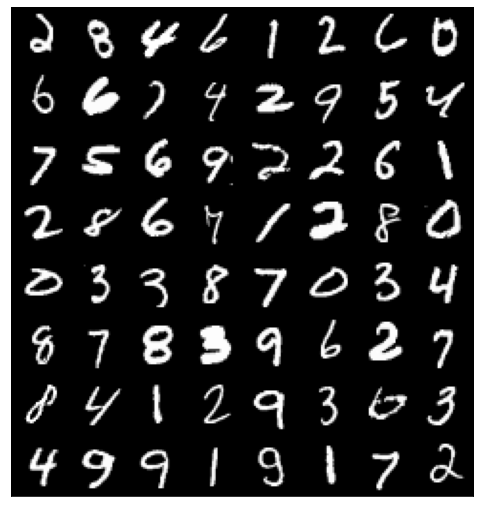

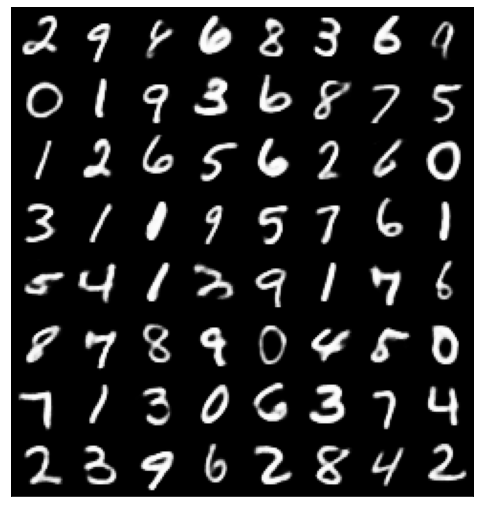

In [7]:
model = VAE(zdim = 20).to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

plot_nm_samples(8, 8, val_loader.dataset, pred = False)
plot_nm_samples(8, 8, val_loader.dataset)

train_losses = []
val_losses = []

for epoch in tqdm(range(80)):
    train_loss, cnt = 0, 0
    model.train()
    for (X, _) in train_loader:
        X = X.to(device)
        optimizer.zero_grad()
        pred, mu, log_sigma = model(X)
        X = X.view(-1, 784)
        loss = criterion(pred, X) + torch.mean(- log_sigma/2 + 1/2 * ( torch.exp(log_sigma) + torch.pow(mu, 2) - 1 ))
        loss.backward()
        optimizer.step()
        train_loss, cnt = train_loss + loss.item(), cnt + 1
    train_loss = train_loss/cnt
    train_losses.append(train_loss)
    val_loss, cnt = 0, 0
    model.eval()
    for (X, _) in val_loader:
        X = X.to(device)
        pred, mu, log_sigma = model(X)
        X = X.view(-1, 784)
        loss = criterion(pred, X) + torch.mean(- log_sigma/2 + 1/2 * ( torch.exp(log_sigma) + torch.pow(mu, 2) - 1 ))
        val_loss, cnt = val_loss + loss.item(), cnt + 1
    val_loss = val_loss/cnt
    val_losses.append(val_loss)
    if (epoch + 1) in [10, 80]:
        plot_nm_samples(8, 8, val_loader.dataset)
    #print(f"Epoch {epoch}, Loss: {loss.item()}")

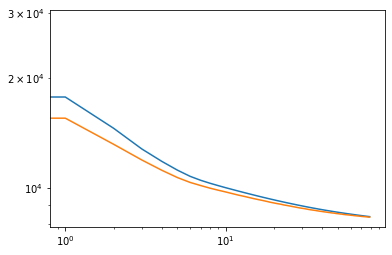

In [8]:
plt.loglog(train_losses)
plt.loglog(val_losses)
plt.show()

# MLT

In [1]:
from googletrans import Translator
translator = Translator()

In [2]:
path_to_utils = 'pyfiles'
import sys
import os
sys.path.append(path_to_utils)
import nmt_dataset
import nnet_models
import numpy as np
import torch
print(torch.__version__)
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from functools import partial
import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy
from subword_nmt.apply_bpe import BPE
%matplotlib inline

1.8.0+cpu


In [45]:
def reset_seed(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

reset_seed(42)

In [46]:
source_lang, target_lang = 'en', 'fr'
data_dir = 'data'
bpe_path = os.path.join(data_dir, 'bpecodes.de-en-fr')


with open(bpe_path) as bpe_codes:
    bpe_model = BPE(bpe_codes)

def preprocess(line, is_source=True, source_lang=None, target_lang=None):
    return bpe_model.segment(line.lower())

def postprocess(line):
    return line.replace('@@ ', '')

def load_data(source_lang, target_lang, split='train', max_size=None):
    # max_size: max number of sentence pairs in the training corpus (None = all)
    path = os.path.join(data_dir, '{}.{}-{}'.format(split, *sorted([source_lang, target_lang])))
    return nmt_dataset.load_dataset(path, source_lang, target_lang, preprocess=preprocess, max_size=max_size) 

In [47]:
train_data = load_data(source_lang, target_lang, 'train', max_size=10000)   # set max_size to 10000 for fast debugging
valid_data = load_data(source_lang, target_lang, 'valid')
test_data = load_data(source_lang, target_lang, 'test')
print(train_data.iloc[:5])

                                         source_data  \
0            armenian is an indo-european language .   
1      you could be a little nicer to your brother .   
2               have you come up with another plan ?   
3  i have to keep my mind on this important quest...   
4                          they crossed the border .   

                                         target_data  \
0     l' armÃ©nien est une langue indo-europÃ©enne .   
1  tu pourrais Ãªtre un peu plus gentil Ã  l' Ã©g...   
2                    as-tu concoctÃ© un autre plan ?   
3  je dois garder Ã  l' esprit cette importante q...   
4                  ils traversÃ¨rent la frontiÃ¨re .   

                                    source_tokenized  \
0  [ar@@, men@@, i@@, an, is, an, in@@, do@@, -@@...   
1  [you, could, be, a, little, ni@@, cer, to, you...   
2      [have, you, come, up, with, another, plan, ?]   
3  [i, have, to, keep, my, mind, on, this, import...   
4            [they, cros@@, sed, the, bor@@, d

In [48]:
model_dir = './model'

source_dict_path = os.path.join(model_dir, 'dict.{}.txt'.format(source_lang))
target_dict_path = os.path.join(model_dir, 'dict.{}.txt'.format(target_lang))

source_dict = nmt_dataset.load_or_create_dictionary(
    source_dict_path,
    train_data['source_tokenized'],
    minimum_count=10,
    reset=False    # set reset to True if you're changing the data or the preprocessing
)
print(source_dict.words[:100])

target_dict = nmt_dataset.load_or_create_dictionary(
    target_dict_path,
    train_data['target_tokenized'],
    minimum_count=10,
    reset=False
)
print(target_dict.words[:100])

['<sos>', '<eos>', '<unk>', '<pad>', '.', 'i', 'you', 'to', 'a', 'the', '?', "'t", 'tom', 'are', 'he', 'do', 'an', 'it', 'is', 'she', 'that', 'me', 'don', 'have', "'s", 'in', 'of', 'want', 'like', 'this', 'can', 'your', "'m", ',', 'was', 'my', 'what', 'on', 'up', 'for', 'be', 'we', 'not', 'with', "'ll", 'all', "'re", 'here', 'no', 'see', 'need', 'as', 'get', 'know', 'at', 'why', 'one', 'did', 'take', 'where', 'ing', 'there', 'were', 'will', 'didn', 'really', 'her', 'his', 'has', 'they', 'had', 'going', 'should', 'how', 'and', 'think', 'about', 'let', 'go', 'who', 'so', 'good', 'mary', 'y', 'could', 'now', 'out', 'if', "'d", "'ve", 'something', 'told', 'day', 'from', 'us', 'just', 're@@', 'ts', 'would', 'today']
['<sos>', '<eos>', '<unk>', '<pad>', 'ã@@', '.', '©@@', 'je', 'un', 'de', '©', 'il', 'a', '?', 'pas', 'que', 'est', 'ne', 'le', 'tom', 'la', "l'", ',', 'vous', 'tu', 'en', '¨@@', 'pour', "n'", 't@@', 'd@@', 'ce', "d'", 'une', 'te', 'ª@@', "j'", 'ai', 'c@@', 're', 'suis', "qu'", 

In [49]:
print('source vocab size:', len(source_dict))
print('target vocab size:', len(target_dict))

source vocab size: 1071
target vocab size: 1207


In [50]:
nmt_dataset.binarize(train_data, source_dict, target_dict, sort=True)
nmt_dataset.binarize(valid_data, source_dict, target_dict, sort=False)
nmt_dataset.binarize(test_data, source_dict, target_dict, sort=False)
print(train_data.iloc[:5])

      source_data  target_data source_tokenized   target_tokenized  \
7176  wonderful !  excellent !   [wonderful, !]     [excellent, !]   
9486         go .         va !          [go, .]            [va, !]   
1080        run .     courez !         [run, .]    [cou@@, rez, !]   
5492       wait !   attendez .        [wait, !]  [atten@@, dez, .]   
1857    come on !      viens !    [come, on, !]         [viens, !]   

             source_bin  source_len         target_bin  target_len  
7176        [2, 156, 1]           3         [2, 65, 1]           3  
9486         [78, 4, 1]           3       [150, 65, 1]           3  
1080        [694, 4, 1]           3  [204, 854, 65, 1]           4  
5492      [690, 156, 1]           3   [937, 734, 5, 1]           4  
1857  [116, 37, 156, 1]           4       [437, 65, 1]           3  


In [51]:
max_len = 30       # maximum 30 tokens per sentence (longer sequences will be truncated)
batch_size = 512   # maximum 512 tokens per batch (decrease if you get OOM errors, increase to speed up training)

reset_seed()

# *****START CODE
train_iterator = nmt_dataset.BatchIterator(train_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=True)
valid_iterator = nmt_dataset.BatchIterator(valid_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=False)
test_iterator = nmt_dataset.BatchIterator(test_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=False)
# *****END CODE

In [52]:
t = next(iter(train_iterator))
t['source'].shape

torch.Size([32, 13])

In [56]:
def save_model(model, checkpoint_path):
    dirname = os.path.dirname(checkpoint_path)
    if dirname:
        os.makedirs(dirname, exist_ok=True)
    torch.save(model, checkpoint_path)

def train_model(
        train_iterator,
        valid_iterators,
        model,
        checkpoint_path,
        epochs=1,
        validation_frequency=1
    ):
    """
    train_iterator: instance of nmt_dataset.BatchIterator or nmt_dataset.MultiBatchIterator
    valid_iterators: list of nmt_dataset.BatchIterator
    model: instance of nnet_models.EncoderDecoder
    checkpoint_path: path of the model checkpoint
    epochs: iterate this many times over train_iterator
    validation_frequency: validate the model every N epochs
    """
    reset_seed()
    
    best_bleu = -1
    grad_norms = []
    for epoch in range(1, epochs + 1):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, epochs))

        # Iterate over training batches for one epoch
        for batch in tqdm(train_iterator, total = len(train_iterator)):
            t = time.time()
            running_loss += model.train_step(batch)
            last_grad = torch.norm(list(model.parameters())[-1].grad)
            grad_norms.append(last_grad)

        # Average training loss for this epoch
        # *****START CODE
        epoch_loss = running_loss / len(train_iterator)
        # *****END CODE

        print("loss={:.3f}, time={:.2f}".format(epoch_loss, time.time() - start))
        print("grad norm={:.3f}".format(last_grad))
        sys.stdout.flush()

        # Evaluate and save the model
        if epoch % validation_frequency == 0:
            bleu_scores = []
            
            # Compute BLEU over all validation sets
            for valid_iterator in valid_iterators:
                # *****START CODE
                src, tgt = valid_iterator.source_lang, valid_iterator.target_lang
                translation_output = model.translate(valid_iterator, postprocess)
                bleu_score = translation_output.score
                output = translation_output.output
                # *****END CODE

                with open(os.path.join(model_dir, 'valid.{}-{}.{}.out'.format(src, tgt, epoch)), 'w') as f:
                    f.writelines(line + '\n' for line in output)

                print('{}-{}: BLEU={}'.format(src, tgt, bleu_score))
                sys.stdout.flush()
                bleu_scores.append(bleu_score)

            # Average the validation BLEU scores
            bleu_score = round(sum(bleu_scores) / len(bleu_scores), 2)
            if len(bleu_scores) > 1:
                print('BLEU={}'.format(bleu_score))

            # Update the model's learning rate based on current performance.
            # This scheduler divides the learning rate by 10 if BLEU does not improve.
            model.scheduler_step(bleu_score)

            # Save a model checkpoint if it has the best validation BLEU so far
            if bleu_score > best_bleu:
                best_bleu = bleu_score
                save_model(model, checkpoint_path)

        print('=' * 50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    return grad_norms

In [57]:
normalize_before = False

In [58]:
transformer_encoder = nnet_models.TransformerEncoder(
    input_size=len(source_dict),
    hidden_size=512,
    num_layers=2,
    dropout=0.0,
    heads=4,
    normalize_before = normalize_before
)

transformer_decoder = nnet_models.TransformerDecoder(
    output_size=len(target_dict),
    hidden_size=512,
    num_layers=2,
    heads=4,
    dropout=0.0,
    normalize_before = normalize_before
)

transformer_model = nnet_models.EncoderDecoder(
    transformer_encoder,
    transformer_decoder,
    lr=0.001,
    use_cuda=True,
    target_dict=target_dict
)

In [ ]:
train_again = True

if train_again:
    checkpoint_path = os.path.join(model_dir, 'transformer.pt')
else:
    checkpoint_path = os.path.join(model_dir, 'pretrained-transformer.pt')

print('checkpoint path:', checkpoint_path)

if os.path.exists(checkpoint_path) and not train_again:
    transformer_model = torch.load(checkpoint_path)
else:
    grad_norms = train_model(train_iterator, [valid_iterator], transformer_model,
                epochs=10,
                checkpoint_path=checkpoint_path, validation_frequency = 5)

In [60]:
print(len(grad_norms))
plt.plot(grad_norms)
plt.show()

2480


In [61]:
normalize_before = True

In [62]:
transformer_encoder = nnet_models.TransformerEncoder(
    input_size=len(source_dict),
    hidden_size=512,
    num_layers=2,
    dropout=0.0,
    heads=4,
    normalize_before = normalize_before
)

transformer_decoder = nnet_models.TransformerDecoder(
    output_size=len(target_dict),
    hidden_size=512,
    num_layers=2,
    heads=4,
    dropout=0.0,
    normalize_before = normalize_before
)

transformer_model = nnet_models.EncoderDecoder(
    transformer_encoder,
    transformer_decoder,
    lr=0.001,
    use_cuda=True,
    target_dict=target_dict
)

In [ ]:
train_again = True

if train_again:
    checkpoint_path = os.path.join(model_dir, 'transformer.pt')
else:
    checkpoint_path = os.path.join(model_dir, 'pretrained-transformer.pt')

print('checkpoint path:', checkpoint_path)

if os.path.exists(checkpoint_path) and not train_again:
    transformer_model = torch.load(checkpoint_path)
else:
    grad_norms_before = train_model(train_iterator, [valid_iterator], transformer_model,
                epochs=10,
                checkpoint_path=checkpoint_path, validation_frequency = 5)

2480


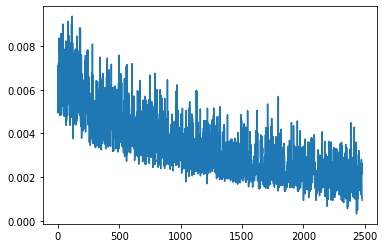

In [64]:
print(len(grad_norms_before))
plt.plot(grad_norms_before)
plt.show()

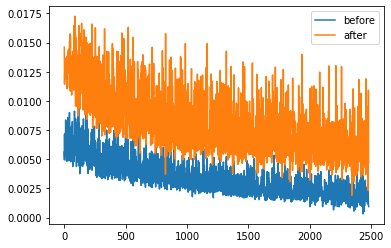

In [65]:
plt.plot(grad_norms_before, label='before')
plt.plot(grad_norms, label='after')
plt.legend()
plt.show()

In [66]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [71]:
smoothed_before = moving_average(grad_norms_before, 10)
smoothed_after = moving_average(grad_norms, 10)

In [72]:
plt.plot(smoothed_before, label='before')
plt.plot(smoothed_after, label='after')
plt.title('Evolution of gradient norm during training \nfor different LayerNormalizations')
plt.xlabel('Training Iteration')
plt.ylabel('Norm of the gradient of the last layer')
plt.legend()
plt.show()

In [73]:
deep_grad_norms_before = grad_norms_before.copy()
deep_grad_norms = grad_norms.copy()

In [74]:
smoothed_before = moving_average(deep_grad_norms_before, 10)
smoothed_after = moving_average(deep_grad_norms, 10)

In [ ]:
plt.plot(smoothed_before, label='before')
plt.plot(smoothed_after, label='after')
plt.title('Evolution of gradient norm during training \nfor different LayerNormalizations')
plt.xlabel('Training Iteration')
plt.ylabel('Norm of the gradient of the last layer')
plt.legend()
plt.show()